In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Assignment 1 for FIT5212, Semester 1, 2021

**Student Name:**  KEWEI SUN

**Student ID:**    30367689

## Load packages

In [5]:
import nltk
import time
import torch
import random
!pip install pyLDAvis==2.1.2
import nltk
from gensim.corpora import Dictionary
import spacy
from gensim.models import LdaModel
from spacy.lang.en import English
import pyLDAvis.gensim
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Phrases
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
nltk.download('stopwords')
random.seed(222)
nltk.download('wordnet')
from torchtext.legacy import data
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from torchtext.legacy.data import TabularDataset
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("english")
from sklearn.model_selection import cross_val_score
from nltk.stem import WordNetLemmatizer 
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import plot_precision_recall_curve, average_precision_score, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, matthews_corrcoef
import numpy as np

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Part 1:  Text Classification

General comments and any shared processing here.

Timer

In [2]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Accuracy calculation

In [3]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

### 2 types of text preprocessing


##### 1: [to lower, remove numbers, remove stop words, stemming]

For Stemming I use the SnowballStemmer from from nltk.stem.


##### 2: [to lower, remove numbers, remove stop words, lemmatisation, remove rare tokens]

For lammatising, I use the WordNetLemmatizer.

In [4]:
def prep1(text):
    # get only word in the text, this step can remove number
    tokenizer = RegexpTokenizer(r'\w+')
    # get the stop words list for english
    stopwords_list = stopwords.words('english')
    tokens = tokenizer.tokenize(text.lower())
    # remove stop word
    rm_stop = [w for w in tokens if w not in stopwords_list]
    # stemming
    stem = [stemmer.stem(w) for w in rm_stop]
    return stem

In [5]:
def prep2(text):
    Lemmatizer = WordNetLemmatizer()
    # get only word in the text, this step can remove number
    tokenizer = RegexpTokenizer(r'\w+')
    stopwords_list = stopwords.words('english')
    #tokenizer.tokenize('Eighty-seven miles to go, yet.  Onward!')
    tokens = tokenizer.tokenize(text.lower())
    # remove those words which word length < 3
    rm_rare_token = [w for w in tokens if len(w) > 3]
    # remove stop word
    rm_stop = [w for w in rm_rare_token if w not in stopwords_list]
    # lemmatizing
    Lemma = [Lemmatizer.lemmatize(w) for w in rm_stop]
    return Lemma

### Prepare data
 Separate the first 1000 row from trainning set, and write to a new .csv file.


In [7]:
# read
train_1000 = pd.read_csv('axcs_train.csv')
# write
train_1000[:1000].to_csv('train1000.csv', index=False)

### Print result

In [8]:
def print_result(train_acc, accuracy, precision, recall, f1score, attr):
  print('-------------------------------------------------------------------------------------')
  print('The Train Accuracy of ' + attr + f' is : {train_acc*100:.2f}%') 
  print('The Test Accuracy of ' + attr + f' is : {accuracy*100:.2f}%')
  print('The Macro Precision of ' + attr + ' is: '+ str(precision))
  print('The Macro Recall of ' + attr + ' is : '+ str(recall))
  print('The Macro F1 score of ' + attr + ' is :'+ str(f1score))
  print('-------------------------------------------------------------------------------------')
  return None

### Part 1A: Statistical Method

Logistical regression model

#### Load data

In [9]:
# Load the dataset into a pandas dataframe.
def read_data(traindata):
  names = ['Abstract', 'InfoTheory', 'CompVis', 'Math']
  df_train = pd.read_csv(traindata)
  df_test = pd.read_csv('axcs_test.csv')
  # get the useful info
  train_data = df_train[names]
  test_data =  df_test[names]
  return train_data, test_data

#### process data

In [10]:
def process_data(df_train, df_test, attr, prep):
  attr = attr
  # get the docs and the label
  trainDocs = df_train.Abstract.tolist()
  testDocs = df_test.Abstract.tolist() 
  trainLabels = eval('df_train.' + attr + '.tolist()')
  testLabels = eval('df_test.' + attr + '.tolist()')
  # define the vevtorizer
  vectorizer=TfidfVectorizer(analyzer='word')
  # do the preprocessing to text
  train_text = [prep(i) for i in trainDocs]
  test_text = [prep(i) for i in testDocs]
  # vevtorize the word in the abstract
  x_train = vectorizer.fit_transform([' '.join(i) for i in train_text])
  x_test = vectorizer.transform([' '.join(i) for i in test_text])
  y_train = np.asarray(trainLabels)
  y_test = np.asarray(testLabels)
  return x_train, y_train, x_test, y_test, attr

#### Logistical regression model

In [11]:
def log_reg(x_train, y_train, x_test, y_test, attr):
  lr = LogisticRegression()
  lr.fit(x_train, y_train)
  # Do the prediction
  y_predict=lr.predict(x_test)
  
  train_predict = lr.predict(x_train)
  train_acc = accuracy_score(y_train,train_predict)
  recall=recall_score(y_test,y_predict,average='macro')
  precision=precision_score(y_test,y_predict,average='macro')
  f1score=f1_score(y_test,y_predict,average='macro')
  accuracy=accuracy_score(y_test,y_predict)
  # print out the result
  print_result(train_acc, accuracy, precision, recall, f1score, attr)
  return lr, accuracy, precision, recall, f1score

### Part 1B: RNN Method (Bi-direction)

Details of method


As well as having an RNN processing the words in the sentence from the first to the last (a forward RNN), we have a second RNN processing the words in the sentence from the last to the first (a backward RNN). At time step $t$, the forward RNN is processing word $x_t$, and the backward RNN is processing word $x_{T-t+1}$.

"Cited from https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/2%20-%20Upgraded%20Sentiment%20Analysis.ipynb"

#### prepare data

 for different size of training data and preproccessing method

In [21]:
MAX_VOCAB_SIZE = 25_000
BATCH_SIZE = 64
EMBEDDING_DIM = 50
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
# set a random seed
SEED = 1234

def preparedata(trainfile, prep):
  # axcs_train.csv & train1000.csv
  # set a random seed

  torch.manual_seed(SEED)
  torch.backends.cudnn.deterministic = True
  TEXT = data.Field(sequential=True, tokenize = prep, include_lengths = True)
  LABEL = data.LabelField(dtype = torch.float)

  tv_datafields = [("ID", None), # we won't be needing the source and notes, so we pass in None as the field
                  ("URL", None),
                  ('Date',None),
                  ('Title',None),
                  ('InfoTheory',LABEL),
                  ('CompVis',LABEL),
                  ('Math',LABEL),
                  ("Abstract", TEXT)]
  # read the data
  train_data, test_data = TabularDataset.splits(
      # path='cola_public/for_torch_text', train='in_domain_train.tsv',
      path='', 
      train=trainfile,
      test='axcs_test.csv',
      format='csv',skip_header=True,
      fields=tv_datafields)
  # split the train data to train data, split ratio = 0.7
  train_data, valid_data = train_data.split(random_state = random.seed(SEED))
  
  # get the size
  print(f'Number of testing examples: {len(test_data)}')
  print(f'Number of training examples: {len(train_data)}')
  print(f'Number ofa validation examples: {len(valid_data)}')
  
  # build vocab using golve.6b.100d, need to download every time dont know why
  TEXT.build_vocab(train_data, 
                  max_size = MAX_VOCAB_SIZE, 
                  vectors = "glove.6B.100d", 
                  unk_init = torch.Tensor.normal_)
  LABEL.build_vocab(train_data)
  # for the rnn we use gpu, more faster
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  # get the iterator, it has sequence
  train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
      (train_data, valid_data, test_data), 
      batch_size = BATCH_SIZE,
      # set sequence is true
      sort_key = lambda x: len(x.Abstract),
      sort_within_batch = True,
      device = device)
  # set the next batch
  batch = next(train_iterator.__iter__())

  # create model
  INPUT_DIM = len(TEXT.vocab)
  PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
  model = RNN(INPUT_DIM, 
              EMBEDDING_DIM, 
              HIDDEN_DIM, 
              OUTPUT_DIM, 
              N_LAYERS, 
              BIDIRECTIONAL, 
              DROPOUT, 
              PAD_IDX)    
  pretrained_embeddings = TEXT.vocab.vectors
  # use Adam as the optimizer method
  optimizer = optim.Adam(model.parameters())
  UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
  model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
  model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
  criterion = nn.BCEWithLogitsLoss()
  model = model.to(device)
  criterion = criterion.to(device)

  return train_iterator, valid_iterator, test_iterator, model, optimizer, criterion

#### Bi-direction LSTM RNN model

In [17]:
# the LSTM returns the output and a tuple of the final hidden state and the final cell state
# the standard RNN only returned the output and final hidden state.
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        # get the embedding for target word
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           # Implementing bidirectionality and adding additional layers
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, text, text_lengths):
        embedded = self.dropout(self.embedding(text))
        #pack sequence make RNN to only process the non-padded elements of our sequence
        # lengths need to be on CPU!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output) 
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        return self.fc(hidden)

def train(model, iterator, optimizer, criterion, attr):
    #initialization
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for batch in iterator:
        # the gradient
        optimizer.zero_grad()
        text, text_lengths = batch.Abstract
        predictions = model(text, text_lengths).squeeze(1)
        # get the loss and accuracy
        loss = eval('criterion(predictions, batch.' + attr + ')')
        acc = eval('binary_accuracy(predictions, batch.' + attr + ')')
        loss.backward()
        optimizer.step()
        # update the parametor
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)
    
def evaluate(model, iterator, criterion, attr):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.Abstract
            predictions = model(text, text_lengths).squeeze(1)
            loss = eval('criterion(predictions, batch.' + attr + ')')
            acc = eval('binary_accuracy(predictions, batch.' + attr + ')')
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

#### Get resualt function



In [18]:
def rnnresult(epochs, attr, train_iterator, valid_iterator, test_iterator, model, optimizer, criterion):
  N_EPOCHS = epochs
  best_valid_loss = float('inf')
  for epoch in range(N_EPOCHS):
      start_time = time.time()
      # train loss and acc
      train_loss, train_acc = train(model, train_iterator, optimizer, criterion, attr)
      # validation
      valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, attr)
      # get the timer
      end_time = time.time()
      epoch_mins, epoch_secs = epoch_time(start_time, end_time)
      # use validation set to reduce overfitting
      if valid_loss < best_valid_loss:
          best_valid_loss = valid_loss
          torch.save(model.state_dict(), 'RNN-model-' + attr + '.pt')

  model.load_state_dict(torch.load('RNN-model-' + attr + '.pt'))

  test_loss, test_acc = evaluate(model, test_iterator, criterion, attr)
      
  y_predict = []
  y_test = []
  p_conf = []

  model.eval()
  with torch.no_grad():
      for batch in test_iterator:
          text, text_lengths = batch.Abstract
          predictions = model(text, text_lengths).squeeze(1)
          preds = torch.sigmoid(predictions)
          rounded_preds = torch.round(preds)
          y_predict += rounded_preds.tolist()
          y_test += eval('batch.' + attr + '.tolist()')
          p_conf += preds.tolist()

  test_list = y_test

  y_predict = np.asarray(y_predict)
  y_test = np.asarray(y_test)
  recall=recall_score(y_test,y_predict,average='macro')
  precision=precision_score(y_test,y_predict,average='macro')
  f1score=f1_score(y_test,y_predict,average='macro')
  accuracy=accuracy_score(y_test,y_predict)
  # print out the result
  print_result(train_acc, accuracy, precision, recall, f1score, attr)

  return accuracy, precision, recall, f1score, test_list, p_conf

### Part 1C:  Results for Methods

F1, precision, etc.

In [22]:
task = ['InfoTheory', 'CompVis', 'Math']

#### **RNN result**

In [23]:
accuracy_rnn_list, precision_rnn_list, recall_rnn_list, f1score_rnn_list, test_list_rnn_list, p_conf_rnn_list = [], [], [], [], [], []

Using all of the data in the axcs_train.csv file + 

[to lower, remove numbers, remove stop words, stemming]



In [ ]:
train_iterator, valid_iterator, test_iterator, model, optimizer, criterion =  preparedata('axcs_train.csv', prep1)
for t in task:
  accuracy, precision, recall, f1score, test_list, p_conf = rnnresult(5, t, train_iterator, valid_iterator, test_iterator, model, optimizer, criterion)
  accuracy_rnn_list.append(accuracy)
  precision_rnn_list.append(precision)
  recall_rnn_list.append(recall)
  f1score_rnn_list.append(f1score)
  test_list_rnn_list.append(test_list)
  p_conf_rnn_list.append(p_conf)

Number of testing examples: 19678
Number of training examples: 38312
Number ofa validation examples: 16419


.vector_cache/glove.6B.zip: 862MB [02:41, 5.33MB/s]                           
100%|█████████▉| 398980/400000 [00:30<00:00, 26277.92it/s]

-------------------------------------------------------------------------------------
The Train Accuracy of InfoTheory is : 94.63%
The Test Accuracy of InfoTheory is : 94.86%
The Macro Precision of InfoTheory is: 0.9305375268399492
The Macro Recall of InfoTheory is : 0.8935267293882223
The Macro F1 score of InfoTheory is :0.9105812637343471
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
The Train Accuracy of CompVis is : 97.61%
The Test Accuracy of CompVis is : 95.64%
The Macro Precision of CompVis is: 0.9371239379511578
The Macro Recall of CompVis is : 0.8279614949133459
The Macro F1 score of CompVis is :0.8724547531052609
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
The Train Accuracy of Math is : 88.54%
The Test Accuracy of Math is : 8

Using all of the data in the axcs_train.csv file + 

[to lower, remove numbers, remove stop words, lemmatisation, remove rare tokens]


In [ ]:
train_iterator, valid_iterator, test_iterator, model, optimizer, criterion =  preparedata('axcs_train.csv', prep2)
for t in task:
  accuracy, precision, recall, f1score, test_list, p_conf = rnnresult(5, t, train_iterator, valid_iterator, test_iterator, model, optimizer, criterion)
  accuracy_rnn_list.append(accuracy)
  precision_rnn_list.append(precision)
  recall_rnn_list.append(recall)
  f1score_rnn_list.append(f1score)
  test_list_rnn_list.append(test_list)
  p_conf_rnn_list.append(p_conf)

Number of testing examples: 19678
Number of training examples: 38312
Number ofa validation examples: 16419
-------------------------------------------------------------------------------------
The Train Accuracy of InfoTheory is : 94.65%
The Test Accuracy of InfoTheory is : 94.40%
The Macro Precision of InfoTheory is: 0.9036874864480935
The Macro Recall of InfoTheory is : 0.9115872240918212
The Macro F1 score of InfoTheory is :0.9075663379493254
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
The Train Accuracy of CompVis is : 97.71%
The Test Accuracy of CompVis is : 95.86%
The Macro Precision of CompVis is: 0.9203735906858208
The Macro Recall of CompVis is : 0.8567029940010529
The Macro F1 score of CompVis is :0.8850934239226673
-------------------------------------------------------------------------------------
--------------------------------------------------

Using the first 1000 row of data in the axcs_train.csv file + 

[to lower, remove numbers, remove stop words, stemming]



In [ ]:
train_iterator, valid_iterator, test_iterator, model, optimizer, criterion =  preparedata('train1000.csv', prep1)
for t in task:
  accuracy, precision, recall, f1score, test_list, p_conf = rnnresult(5, t, train_iterator, valid_iterator, test_iterator, model, optimizer, criterion)
  accuracy_rnn_list.append(accuracy)
  precision_rnn_list.append(precision)
  recall_rnn_list.append(recall)
  f1score_rnn_list.append(f1score)
  test_list_rnn_list.append(test_list)
  p_conf_rnn_list.append(p_conf)

Number of testing examples: 19678
Number of training examples: 700
Number ofa validation examples: 300
-------------------------------------------------------------------------------------
The Train Accuracy of InfoTheory is : 99.72%
The Test Accuracy of InfoTheory is : 81.62%
The Macro Precision of InfoTheory is: 0.40812074397804654
The Macro Recall of InfoTheory is : 0.5
The Macro F1 score of InfoTheory is :0.44941242305540013
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
The Train Accuracy of CompVis is : 100.00%
The Test Accuracy of CompVis is : 89.06%
The Macro Precision of CompVis is: 0.44531964630551885
The Macro Recall of CompVis is : 0.5
The Macro F1 score of CompVis is :0.4710783786689603
-------------------------------------------------------------------------------------
--------------------------------------------------------------------------------

Using the first 1000 row of data in the axcs_train.csv file + 

[to lower, remove numbers, remove stop words, lemmatisation, remove rare tokens]


In [24]:
train_iterator, valid_iterator, test_iterator, model, optimizer, criterion =  preparedata('train1000.csv', prep2)
for t in task:
  accuracy, precision, recall, f1score, test_list, p_conf = rnnresult(5, t, train_iterator, valid_iterator, test_iterator, model, optimizer, criterion)
  accuracy_rnn_list.append(accuracy)
  precision_rnn_list.append(precision)
  recall_rnn_list.append(recall)
  f1score_rnn_list.append(f1score)
  test_list_rnn_list.append(test_list)
  p_conf_rnn_list.append(p_conf)

.vector_cache/glove.6B.zip: 0.00B [00:00, ?B/s]

Number of testing examples: 19678
Number of training examples: 700
Number ofa validation examples: 300


.vector_cache/glove.6B.zip: 862MB [02:41, 5.35MB/s]                           
100%|█████████▉| 398825/400000 [00:29<00:00, 25779.36it/s]

-------------------------------------------------------------------------------------
The Train Accuracy of InfoTheory is : 99.72%
The Test Accuracy of InfoTheory is : 81.62%
The Macro Precision of InfoTheory is: 0.40812074397804654
The Macro Recall of InfoTheory is : 0.5
The Macro F1 score of InfoTheory is :0.44941242305540013
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
The Train Accuracy of CompVis is : 100.00%
The Test Accuracy of CompVis is : 89.06%
The Macro Precision of CompVis is: 0.44531964630551885
The Macro Recall of CompVis is : 0.5
The Macro F1 score of CompVis is :0.4710783786689603
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
The Train Accuracy of Math is : 97.58%
The Test Accuracy of Math is : 69.86%
The Macro Precision 

#### **Logistical regression result**

In [ ]:
# save record for plot
lr_list, x_test_list, y_test_list, accuracy_list, precision_list, recall_list, f1score_list = [], [], [], [], [], [], []

Using all of the data in the axcs_train.csv file + 

[to lower, remove numbers, remove stop words, stemming]



In [ ]:
train_data, test_data = read_data('axcs_train.csv')
for t in task:
  x_train, y_train, x_test, y_test, attr = process_data(train_data, test_data, t, prep1)
  lr, accuracy, precision, recall, f1score = log_reg(x_train, y_train, x_test, y_test, attr)
  lr_list.append(lr)
  x_test_list.append(x_test)
  y_test_list.append(y_test)
  accuracy_list.append(accuracy)
  precision_list.append(precision)
  recall_list.append(recall)
  f1score_list.append(f1score)

-------------------------------------------------------------------------------------
The Train Accuracy of InfoTheory is : 95.96%
The Test Accuracy of InfoTheory is : 94.80%
The Macro Precision of InfoTheory is: 0.9425963885881121
The Macro Recall of InfoTheory is : 0.8791932023916174
The Macro F1 score of InfoTheory is :0.9067483826731856
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
The Train Accuracy of CompVis is : 98.40%
The Test Accuracy of CompVis is : 96.06%
The Macro Precision of CompVis is: 0.9563872028665801
The Macro Recall of CompVis is : 0.8347847616308346
The Macro F1 score of CompVis is :0.8835760502007933
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
The Train Accuracy of Math is : 90.39%
The Test Accuracy of Math is : 8

Using all of the data in the axcs_train.csv file + 

[to lower, remove numbers, remove stop words, lemmatisation, remove rare tokens]


In [ ]:
train_data, test_data = read_data('axcs_train.csv')
for t in task:
  x_train, y_train, x_test, y_test, attr = process_data(train_data, test_data, t, prep2)
  lr, accuracy, precision, recall, f1score = log_reg(x_train, y_train, x_test, y_test, attr)
  lr_list.append(lr)
  x_test_list.append(x_test)
  y_test_list.append(y_test)
  accuracy_list.append(accuracy)
  precision_list.append(precision)
  recall_list.append(recall)
  f1score_list.append(f1score)


-------------------------------------------------------------------------------------
The Train Accuracy of InfoTheory is : 96.01%
The Test Accuracy of InfoTheory is : 94.74%
The Macro Precision of InfoTheory is: 0.9420436035202082
The Macro Recall of InfoTheory is : 0.8777793296551086
The Macro F1 score of InfoTheory is :0.9056437974025807
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
The Train Accuracy of CompVis is : 98.43%
The Test Accuracy of CompVis is : 95.85%
The Macro Precision of CompVis is: 0.9551910716178484
The Macro Recall of CompVis is : 0.8248511133962626
The Macro F1 score of CompVis is :0.8760619877930864
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
The Train Accuracy of Math is : 90.69%
The Test Accuracy of Math is : 8

Using the first 1000 row of data in the axcs_train.csv file + 

[to lower, remove numbers, remove stop words, stemming]



In [ ]:
train_data, test_data = read_data('train1000.csv')
for t in task:
  x_train, y_train, x_test, y_test, attr = process_data(train_data, test_data, t, prep1)
  lr, accuracy, precision, recall, f1score = log_reg(x_train, y_train, x_test, y_test, attr)
  lr_list.append(lr)
  x_test_list.append(x_test)
  y_test_list.append(y_test)
  accuracy_list.append(accuracy)
  precision_list.append(precision)
  recall_list.append(recall)
  f1score_list.append(f1score)

-------------------------------------------------------------------------------------
The Train Accuracy of InfoTheory is : 99.80%
The Test Accuracy of InfoTheory is : 81.62%
The Macro Precision of InfoTheory is: 0.40812074397804654
The Macro Recall of InfoTheory is : 0.5
The Macro F1 score of InfoTheory is :0.44941242305540013
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
The Train Accuracy of CompVis is : 99.90%
The Test Accuracy of CompVis is : 89.06%
The Macro Precision of CompVis is: 0.44531964630551885
The Macro Recall of CompVis is : 0.5
The Macro F1 score of CompVis is :0.4710783786689603
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
The Train Accuracy of Math is : 97.60%
The Test Accuracy of Math is : 69.86%
The Macro Precision o

Using the first 1000 row of data in the axcs_train.csv file + 

[to lower, remove numbers, remove stop words, lemmatisation, remove rare tokens]


In [ ]:
train_data, test_data = read_data('train1000.csv')
for t in task:
  x_train, y_train, x_test, y_test, attr = process_data(train_data, test_data, t, prep2)
  lr, accuracy, precision, recall, f1score = log_reg(x_train, y_train, x_test, y_test, attr)
  lr_list.append(lr)
  x_test_list.append(x_test)
  y_test_list.append(y_test)
  accuracy_list.append(accuracy)
  precision_list.append(precision)
  recall_list.append(recall)
  f1score_list.append(f1score)


-------------------------------------------------------------------------------------
The Train Accuracy of InfoTheory is : 99.80%
The Test Accuracy of InfoTheory is : 81.62%
The Macro Precision of InfoTheory is: 0.40812074397804654
The Macro Recall of InfoTheory is : 0.5
The Macro F1 score of InfoTheory is :0.44941242305540013
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
The Train Accuracy of CompVis is : 99.90%
The Test Accuracy of CompVis is : 89.06%
The Macro Precision of CompVis is: 0.44531964630551885
The Macro Recall of CompVis is : 0.5
The Macro F1 score of CompVis is :0.4710783786689603
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
The Train Accuracy of Math is : 97.60%
The Test Accuracy of Math is : 69.86%
The Macro Precision o

### Part 1D: Plots for Methods

F1, precision, etc.


#### Logistical regression precision-recall-curve plot

In [ ]:
i = 0
def plot_lr(lr, x_test, y_test):
  # plot the precision recall curve
  y_score = lr.decision_function(x_test)
  average_precision = average_precision_score(y_test, y_score)
  disp = plot_precision_recall_curve(lr, x_test, y_test)
  disp.ax_.set_title('Precision-Recall curve: '
                    'AP = {0:0.2f}'.format(average_precision))
  return None

1. all data + [to lower, remove numbers, remove stop words, stemming] + InfoTheory



In [ ]:
len(x_test_list)


12

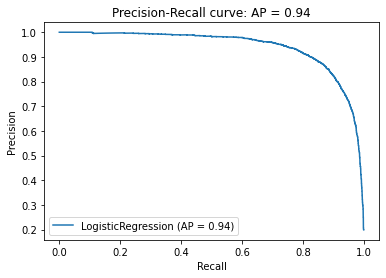

In [ ]:

plot_lr(lr_list[i], x_test_list[i], y_test_list[i])
i+=1

2. all data + [to lower, remove numbers, remove stop words, stemming] + CompVis



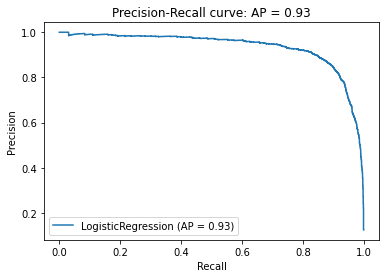

In [ ]:
plot_lr(lr_list[i], x_test_list[i], y_test_list[i])
i+=1

3. all data + [to lower, remove numbers, remove stop words, stemming] + Math



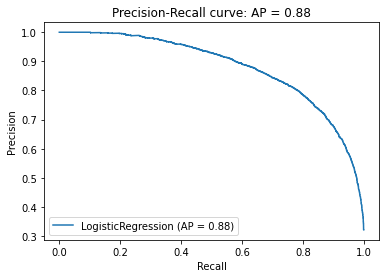

In [ ]:
plot_lr(lr_list[i], x_test_list[i], y_test_list[i])
i+=1

4. all data + [to lower, remove numbers, remove stop words, lemmatisation, remove rare tokens] + InfoTheory



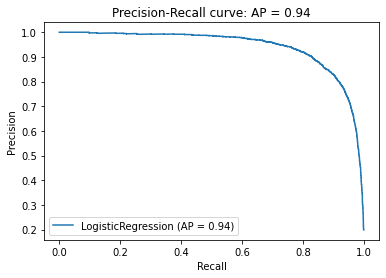

In [ ]:
plot_lr(lr_list[i], x_test_list[i], y_test_list[i])
i+=1

5. all data + [to lower, remove numbers, remove stop words, lemmatisation, remove rare tokens] + CompVis



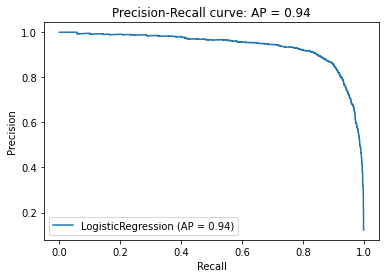

In [ ]:
plot_lr(lr_list[i], x_test_list[i], y_test_list[i])
i+=1

6. all data + [to lower, remove numbers, remove stop words, lemmatisation, remove rare tokens] + Math



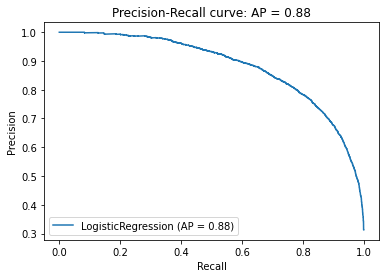

In [ ]:
plot_lr(lr_list[i], x_test_list[i], y_test_list[i])
i+=1

7. first 1000 row data + [to lower, remove numbers, remove stop words, stemming] + InfoTheory



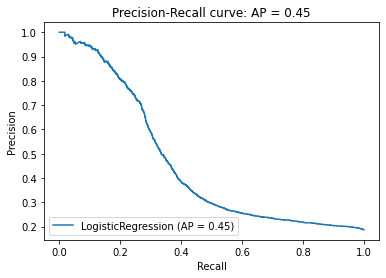

In [ ]:
plot_lr(lr_list[i], x_test_list[i], y_test_list[i])
i+=1

8. first 1000 row data + [to lower, remove numbers, remove stop words, stemming] + CompVis



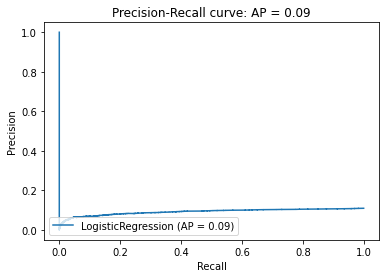

In [ ]:
plot_lr(lr_list[i], x_test_list[i], y_test_list[i])
i+=1

9. first 1000 row data + [to lower, remove numbers, remove stop words, stemming] + Math



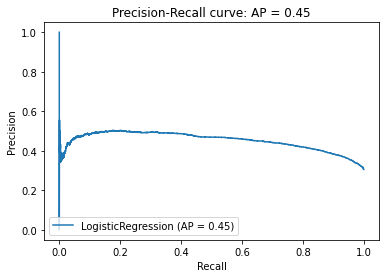

In [ ]:
plot_lr(lr_list[i], x_test_list[i], y_test_list[i])
i+=1

10. first 1000 row data + [to lower, remove numbers, remove stop words, lemmatisation, remove rare tokens] + InfoTheory



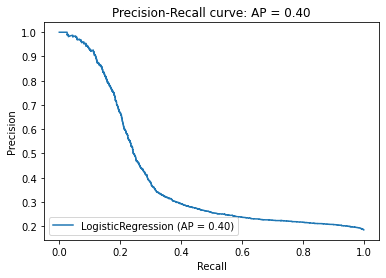

In [ ]:
plot_lr(lr_list[i], x_test_list[i], y_test_list[i])
i+=1

11. first 1000 row data + [to lower, remove numbers, remove stop words, lemmatisation, remove rare tokens] + CompVis



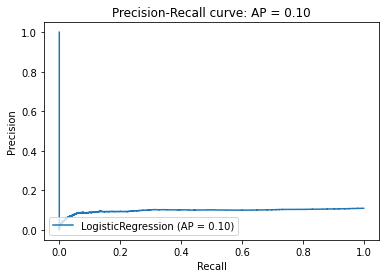

In [ ]:
plot_lr(lr_list[i], x_test_list[i], y_test_list[i])
i+=1

12. first 1000 row data + [to lower, remove numbers, remove stop words, lemmatisation, remove rare tokens] + Math



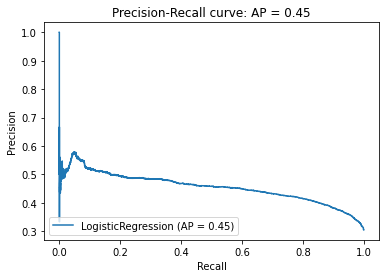

In [ ]:
plot_lr(lr_list[i], x_test_list[i], y_test_list[i])

#### RNN precision-recall-curve plot

**plot precision-recall-curve function for RNN model**



In [ ]:
i = 0
def rnn_plot(y_test_list, p_conf):
  # initializ the list
  P, R, sort = [], [], []
  # turn the list to a np array for use argsort function
  p_conf = np.array(p_conf)
  # sort the array big to small
  for i in np.argsort(-p_conf):
    sort.append([p_conf[i], y_test_list[i]])
  for i in range(len(sort)):
    TP, FP, FN = 0, 0, 0
    # positive and ture
    for j in sort[:i+1]:
      if int(j[1]) == 1:
        TP += 1
      else:
        FP += 1
    # nagitive and false
    for a in sort[i+1:]:
      if int(a[1]) == 1:
        FN +=1
    # calcualte the precision and recall
    P.append(TP/(TP+FP))
    R.append(TP/(TP+FN))
  # plot the curve
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.plot(R,P)
  return None

1. all data + [to lower, remove numbers, remove stop words, stemming] + InfoTheory



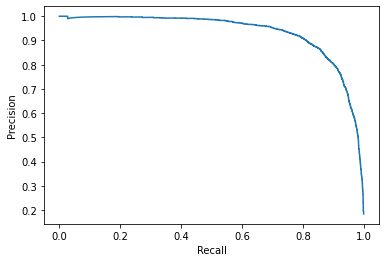

In [ ]:
rnn_plot(test_list_rnn_list[i], p_conf_rnn_list[i])
i += 1

2. all data + [to lower, remove numbers, remove stop words, stemming] + CompVis



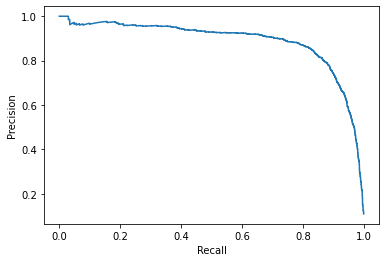

In [ ]:
rnn_plot(test_list_rnn_list[i], p_conf_rnn_list[i])
i += 1

3. all data + [to lower, remove numbers, remove stop words, stemming] + Math



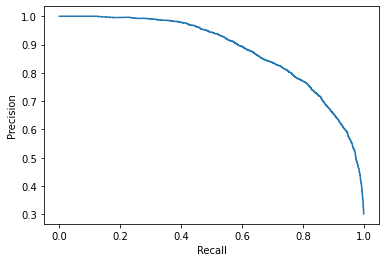

In [ ]:
rnn_plot(test_list_rnn_list[i], p_conf_rnn_list[i])
i += 1

4. all data + [to lower, remove numbers, remove stop words, lemmatisation, remove rare tokens] + InfoTheory



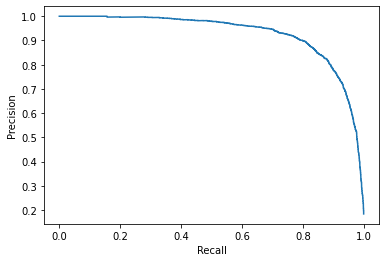

In [ ]:
rnn_plot(test_list_rnn_list[i], p_conf_rnn_list[i])
i += 1

5. all data + [to lower, remove numbers, remove stop words, lemmatisation, remove rare tokens] + CompVis



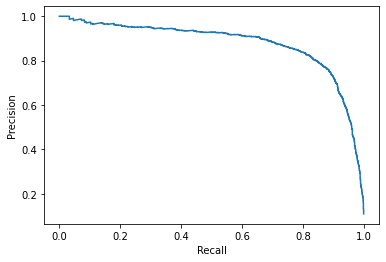

In [ ]:
rnn_plot(test_list_rnn_list[i], p_conf_rnn_list[i])
i += 1

6. all data + [to lower, remove numbers, remove stop words, lemmatisation, remove rare tokens] + Math



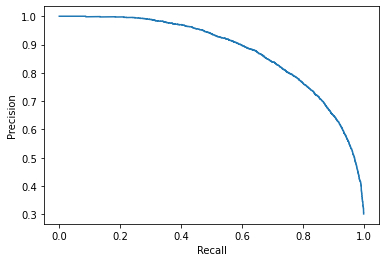

In [ ]:
rnn_plot(test_list_rnn_list[i], p_conf_rnn_list[i])
i += 1

7. first 1000 row data + [to lower, remove numbers, remove stop words, stemming] + InfoTheory



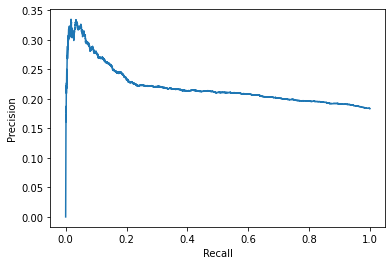

In [ ]:
rnn_plot(test_list_rnn_list[i], p_conf_rnn_list[i])
i += 1

8. first 1000 row data + [to lower, remove numbers, remove stop words, stemming] + CompVis



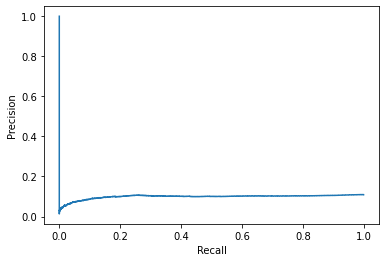

In [ ]:
rnn_plot(test_list_rnn_list[i], p_conf_rnn_list[i])
i += 1

9. first 1000 row data + [to lower, remove numbers, remove stop words, stemming] + Math



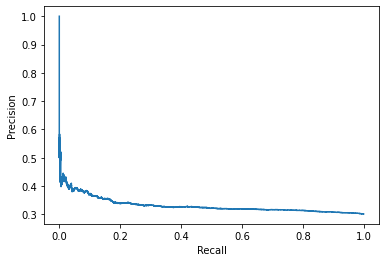

In [ ]:
rnn_plot(test_list_rnn_list[i], p_conf_rnn_list[i])
i += 1

10. first 1000 row data + [to lower, remove numbers, remove stop words, lemmatisation, remove rare tokens] + InfoTheory



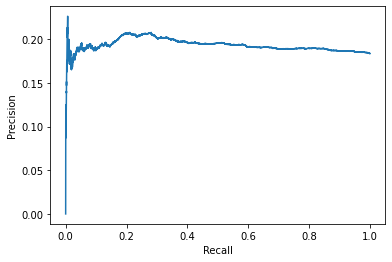

In [ ]:
rnn_plot(test_list_rnn_list[i], p_conf_rnn_list[i])
i += 1

11. first 1000 row data + [to lower, remove numbers, remove stop words, lemmatisation, remove rare tokens] + CompVis



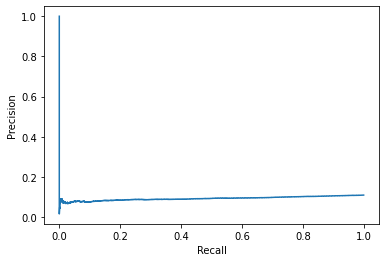

In [ ]:
rnn_plot(test_list_rnn_list[i], p_conf_rnn_list[i])
i += 1

12. first 1000 row data + [to lower, remove numbers, remove stop words, lemmatisation, remove rare tokens] + Math



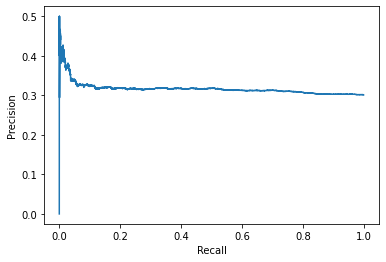

In [ ]:
rnn_plot(test_list_rnn_list[i], p_conf_rnn_list[i])
i += 1

## Part 2: Topic Modelling

General comments and any shared processing here.


### Load data

In [9]:
def lda_read_data(rows):
  # uncomment and run to load up this data
  text_data = []
  df = pd.read_csv('axcs_train.csv')
  df = df[:rows]
  docs = df['Abstract'].tolist()
  raw_docs = docs.copy()
  return raw_docs, docs

### 2 types of preprocessing

#### Preprocessing 1

lower + RegxpTokenizer + remove numbers + remove short word(len<1) + SnowballStemming + occur less than 50 or more than 50% of the documents

In [14]:
def preprocess1(docs):
  # Split the documents into tokens.
  tokenizer = RegexpTokenizer(r'\w+')
  for idx in range(len(docs)):
      docs[idx] = docs[idx].lower()  # Convert to lowercase.
      docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.
  # Remove numbers, but not words that contain numbers.
  docs = [[token for token in doc if not token.isnumeric()] for doc in docs]
  # Remove words that are only one character.
  docs = [[token for token in doc if len(token) > 1] for doc in docs]
  # Stemming the documents.
  stemmer = SnowballStemmer("english")
  docs = [[stemmer.stem(token) for token in doc] for doc in docs]
  # Remove rare and common tokens.
  # Create a dictionary representation of the documents.
  dictionary = Dictionary(docs)
  # Filter out words that occur less than 50 documents, or more than 50% of the documents.
  dictionary.filter_extremes(no_below=50, no_above=0.5)
  # Bag-of-words representation of the documents.
  corpus = [dictionary.doc2bow(doc) for doc in docs]
  return corpus, dictionary

#### Preprocessing 2

lower + spacy tokenizer + remove short word(len<1) + lematizeing + bigram + occur less than 50 or more than 50% of the documents

In [15]:
def preprocess2(docs):
  nlp = spacy.load('en_core_web_sm')
  # Split the documents into tokens.
  for idx in range(len(docs)):
      docs[idx] = docs[idx].lower()  # Convert to lowercase.
      docs[idx] = nlp(docs[idx])  # Split into words.
  # Remove words that are only one character.
  docs = [[token for token in doc if len(token) > 1] for doc in docs]
  # Lemmatize the documents.
  docs = [[token.lemma_ for token in doc] for doc in docs]
  # Add bigrams and trigrams to docs (only ones that appear 20 times or more).
  bigram = Phrases(docs, min_count=20)
  for idx in range(len(docs)):
      for token in bigram[docs[idx]]:
          if '_' in token:
              # Token is a bigram, add to document.
              docs[idx].append(token)
  # Remove rare and common tokens.
  # Create a dictionary representation of the documents.
  dictionary = Dictionary(docs)
  # Filter out words that occur less than 20 documents, or more than 50% of the documents.
  dictionary.filter_extremes(no_below=20, no_above=0.5)
  # Bag-of-words representation of the documents.
  corpus = [dictionary.doc2bow(doc) for doc in docs]
  return corpus, dictionary

### Train and get the plot of LDA topic model

In [16]:
def LDA_topic(K, corpus, dictionary):
  # Train LDA model.
  # Set training parameters.
  NUM_TOPICS = K
  chunksize = 2000
  passes = 20
  iterations = 400
  eval_every = None  # Don't evaluate model perplexity, takes too much time.
  # Make a index to word dictionary.
  temp = dictionary[0]  # This is only to "load" the dictionary.
  id2word = dictionary.id2token

  model = LdaModel(
      corpus=corpus,
      id2word=id2word,
      chunksize=chunksize,
      alpha='auto',
      eta='auto',
      iterations=iterations,
      num_topics=NUM_TOPICS,
      passes=passes,
      eval_every=eval_every
  )
  top_topics = model.top_topics(corpus) #, num_words=20)
  # Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
  avg_topic_coherence = sum([t[1] for t in top_topics]) / NUM_TOPICS
  lda_display = pyLDAvis.gensim.prepare(model, corpus, dictionary, sort_topics=False)
  
  return lda_display, model

### Visualisation

In [17]:
def get_document_topics(ldamodel, corpus, texts):
   # Init output
    document_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                document_topics_df = document_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    document_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    document_topics_df = pd.concat([document_topics_df, contents], axis=1)

    document_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Original_Text']

    return document_topics_df

#### Apply preprocessing 1, K = 10 to First 1000 rows data

In [19]:
# get the first 1000 rows data
raw_docs, docs = lda_read_data(1000)
corpus, dictionary = preprocess1(docs)
lda_display, model = LDA_topic(10, corpus, dictionary)
# get the plot
pyLDAvis.display(lda_display)

In [20]:
doc_topic_df = get_document_topics(ldamodel=model, corpus=corpus, texts=raw_docs)
doc_topic_df.head()

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Original_Text
0,7.0,0.4980,"algorithm, pars, grammar, parser, it, be, can,...",Nested satisfiability A special case of the s...
1,4.0,0.9244,"text, word, method, from, by, corpus, lexic, b...",A note on digitized angles We study the confi...
2,5.0,0.9605,"languag, natur, system, context, process, as, ...",Textbook examples of recursion We discuss pro...
3,9.0,0.8653,"translat, languag, system, as, it, be, process...",Theory and practice The author argues to Sili...
4,0.0,0.4030,"word, sens, program, model, learn, order, clas...",Context-free multilanguages This article is a...


#### Apply preprocessing 2, K = 40 to First 1000 rows data

In [23]:
# get the first 1000 rows data
raw_docs, docs = lda_read_data(1000)
corpus, dictionary = preprocess2(docs)
lda_display, model = LDA_topic(40, corpus, dictionary)
# get the plot
pyLDAvis.display(lda_display)

In [24]:
doc_topic_df = get_document_topics(ldamodel=model, corpus=corpus, texts=raw_docs)
doc_topic_df.head()

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Original_Text
0,27.0,0.5620,"discourse, structure, algorithm, as, which, co...",Nested satisfiability A special case of the s...
1,39.0,0.5486,"algorithm, problem, time, by, show, can, searc...",A note on digitized angles We study the confi...
2,37.0,0.9472,"english, tree, translation, machine, language,...",Textbook examples of recursion We discuss pro...
3,22.0,0.4825,"theory, domain, as, program, representation, s...",Theory and practice The author argues to Sili...
4,6.0,0.3100,"grammar, parse, parsing, free, categorial, par...",Context-free multilanguages This article is a...


--------------------------------

#### Apply preprocessing 1, K = 10 to first 20000 rows data

In [25]:
# get the first 20000 rows data
raw_docs, docs = lda_read_data(20000)
corpus, dictionary = preprocess1(docs)
lda_display, model = LDA_topic(10, corpus, dictionary)
# get the plot
pyLDAvis.display(lda_display)

In [26]:
doc_topic_df = get_document_topics(ldamodel=model, corpus=corpus, texts=raw_docs)
doc_topic_df.head()

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Original_Text
0,6.0,0.5979,"graph, bound, set, problem, be, number, show, ...",Nested satisfiability A special case of the s...
1,6.0,0.4191,"graph, bound, set, problem, be, number, show, ...",A note on digitized angles We study the confi...
2,2.0,0.9447,"model, languag, as, program, logic, system, be...",Textbook examples of recursion We discuss pro...
3,1.0,0.4867,"system, design, it, as, be, base, applic, pape...",Theory and practice The author argues to Sili...
4,2.0,0.7196,"model, languag, as, program, logic, system, be...",Context-free multilanguages This article is a...


#### Apply preprocessing 2, K = 40 to first 20000 rows data

In [27]:
# get the first 20000 rows data
raw_docs, docs = lda_read_data(20000)
corpus, dictionary = preprocess2(docs)
lda_display, model = LDA_topic(40, corpus, dictionary)
# get the plot
pyLDAvis.display(lda_display)

In [28]:
doc_topic_df = get_document_topics(ldamodel=model, corpus=corpus, texts=raw_docs)


,Dominant_Topic,Perc_Contribution,Topic_Keywords,Original_Text
0,6.0,0.6005,"problem, show, set, show_that, polynomial, giv...",Nested satisfiability A special case of the s...
1,38.0,0.3189,"path, each, cost, multi, phase, two, player, h...",A note on digitized angles We study the confi...
2,30.0,0.2815,"function, complexity, theory, proof, theorem, ...",Textbook examples of recursion We discuss pro...
3,16.0,0.5095,"have, as, from, some, these, paper, study, res...",Theory and practice The author argues to Sili...
4,4.0,0.2611,"language, finite, word, free, state, fuzzy, au...",Context-free multilanguages This article is a...


In [ ]:
doc_topic_df.head()

## Reference


RNN code from https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/2%20-%20Upgraded%20Sentiment%20Analysis.ipynb